Shape: (225745, 79)
Label column found: True
Numeric features: 78
Dropping 26 highly correlated columns
Scaled shape: (225745, 42)
k=1 inertia=416023.60
k=2 inertia=351494.17
k=3 inertia=320852.75
k=4 inertia=277546.95
k=5 inertia=264488.29
k=6 inertia=249213.47


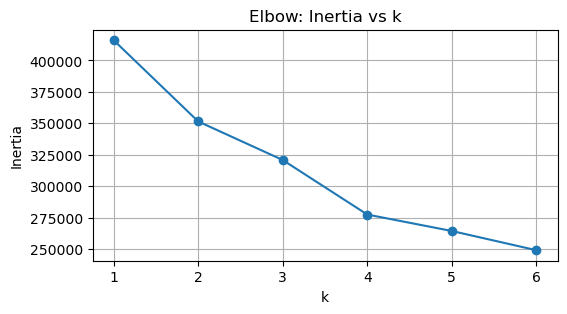

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

# ----------------- USER PARAMETERS -----------------
FILE_PATH = "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"  # path ke file
SAMPLE_N = 10000        # gunakan sample untuk langkah seleksi (None = pakai semua)
SILHOUETTE_SAMPLE_N = 2000
MAX_K = 6               # max k yang akan dites (elbow/silhouette)
RANDOM_STATE = 42
OUT_FULL = "kmeans_results_full.csv"
OUT_SAMPLE = "kmeans_results_sample.csv"
# ---------------------------------------------------

# 1) Load & cleaning nama kolom
df = pd.read_csv(FILE_PATH)
df.columns = df.columns.str.strip()   # hapus leading/trailing spaces
print("Shape:", df.shape)
label_col = "Label" if "Label" in df.columns else None
print("Label column found:", label_col is not None)

# 2) Pilih fitur numerik (jangan ambil label)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if label_col and label_col in num_cols:
    num_cols.remove(label_col)
print("Numeric features:", len(num_cols))

df_num = df[num_cols].copy()

# 3) Tangani INF / NaN
df_num.replace([np.inf, -np.inf], np.nan, inplace=True)
if df_num.isnull().sum().sum() > 0:
    df_num = df_num.fillna(df_num.median())   # imputasi median

# 4) Hilangkan fitur near-constant (variance threshold)
vt = VarianceThreshold(threshold=1e-8)
vt.fit(df_num)
df_num = df_num.loc[:, vt.get_support()]

# 5) Hapus fitur yang sangat berkorelasi (|corr| > 0.95)
corr = df_num.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.95)]
print("Dropping", len(to_drop), "highly correlated columns")
df_num_reduced = df_num.drop(columns=to_drop)

# 6) Standarisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_num_reduced)
print("Scaled shape:", X_scaled.shape)

# 7) Sampling untuk langkah pemilihan k (cepat)
n_total = X_scaled.shape[0]
if SAMPLE_N is None or SAMPLE_N >= n_total:
    sample_idx = np.arange(n_total)
else:
    rng = np.random.RandomState(RANDOM_STATE)
    sample_idx = rng.choice(n_total, size=SAMPLE_N, replace=False)
X_sample = X_scaled[sample_idx]

# 8) Elbow (inertia) — gunakan MiniBatchKMeans untuk kecepatan
inertias = []
for k in range(1, MAX_K + 1):
    mbk = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=5, batch_size=2000)
    mbk.fit(X_sample)
    inertias.append(mbk.inertia_)
    print(f"k={k} inertia={mbk.inertia_:.2f}")

plt.figure(figsize=(6,3))
plt.plot(range(1, MAX_K+1), inertias, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow: Inertia vs k")
plt.grid(True)
plt.show()

k=2 silhouette=0.2393
k=3 silhouette=0.2907
k=4 silhouette=0.2991
k=5 silhouette=0.2859
k=6 silhouette=0.3307


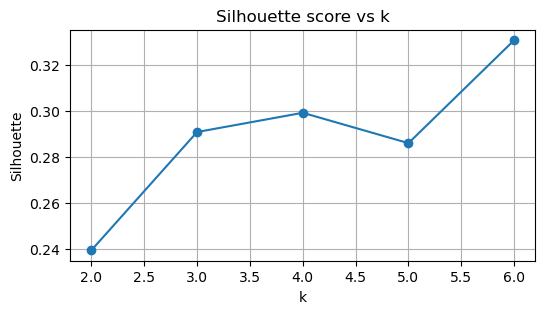

Suggested k (by silhouette): 6
Saved outputs: kmeans_results_full.csv kmeans_results_sample.csv
Label           BENIGN   DDoS
kmeans_cluster               
0                33931  47429
1                 9552      0
2                14870  36150
3                 5728  22892
4                 1345  21502
5                32292     54

Proporsi per cluster:
Label             BENIGN      DDoS
kmeans_cluster                    
0               0.417048  0.582952
1               1.000000  0.000000
2               0.291454  0.708546
3               0.200140  0.799860
4               0.058870  0.941130
5               0.998331  0.001669


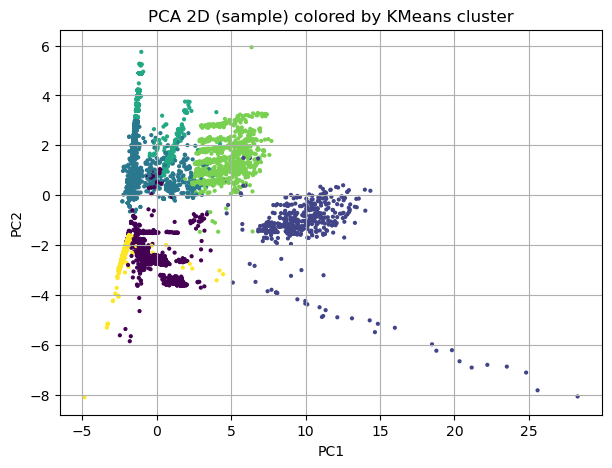

In [2]:

# 9) Silhouette score (k=2..MAX_K) — hitung pada subset kecil
sil_scores = []
k_range = range(2, MAX_K + 1)
sil_sample_n = min(SILHOUETTE_SAMPLE_N, X_sample.shape[0])
rng = np.random.RandomState(RANDOM_STATE+1)
sil_idx = rng.choice(X_sample.shape[0], size=sil_sample_n, replace=False)
X_sil = X_sample[sil_idx]

for k in k_range:
    mbk = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=5, batch_size=2000)
    preds = mbk.fit_predict(X_sil)
    score = silhouette_score(X_sil, preds)
    sil_scores.append(score)
    print(f"k={k} silhouette={score:.4f}")

plt.figure(figsize=(6,3))
plt.plot(list(k_range), sil_scores, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette score vs k")
plt.grid(True)
plt.show()

# 10) Pilih k (otomatis: maksimum silhouette) — atau pilih manual dari plot
best_k = int(k_range[np.argmax(sil_scores)])
print("Suggested k (by silhouette):", best_k)

# 11) Latih final model (MiniBatchKMeans untuk dataset besar)
#     - Jika dataset kecil/menengah dan ingin akurasi sedikit lebih baik: pakai KMeans
if n_total > 50000:
    model = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=20, batch_size=5000)
else:
    model = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)

# fit pada SAMPLE (cepat), lalu predict ke semua baris menggunakan centroid
model.fit(X_sample)
clusters_all = model.predict(X_scaled)

# 12) Lampirkan label cluster ke df dan simpan
df_out = df.copy()
df_out["kmeans_cluster"] = clusters_all
df_out.to_csv(OUT_FULL, index=False)
df_out.iloc[sample_idx].to_csv(OUT_SAMPLE, index=False)
print("Saved outputs:", OUT_FULL, OUT_SAMPLE)

# 13) Evaluasi sederhana: bandingkan cluster vs Label (jika ada)
if label_col:
    print(pd.crosstab(df_out["kmeans_cluster"], df_out[label_col]))
    print("\nProporsi per cluster:")
    print(pd.crosstab(df_out["kmeans_cluster"], df_out[label_col], normalize="index"))

# 14) Visualisasi 2D via PCA (plot sample)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_sample_pca = pca.fit_transform(X_sample)
sample_preds = model.predict(X_sample)
plt.figure(figsize=(7,5))
plt.scatter(X_sample_pca[:,0], X_sample_pca[:,1], s=4, c=sample_preds)  # warna default colormap
plt.title("PCA 2D (sample) colored by KMeans cluster")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True)
plt.show()